# Estimation of needed physical qubits and couplers

In [40]:
from minorminer import find_embedding
import numpy as np
import matplotlib.pyplot as plt
from dimod import BinaryQuadraticModel
from dwave.system import DWaveSampler, EmbeddingComposite
import networkx as nx
import random

In [16]:
def create_qubo_gi(E1,E2,vertices,p):
    Q = np.zeros((vertices*vertices, vertices*vertices))
    
    # Constraint 1: penalty if several mappings from same source
    for i in range(vertices): 
        for j in range(vertices): 
            for k in range(j+1,vertices): 
                Q[i*vertices+j,i*vertices+k]=p 

    # Constaint 2: penalty if several mappings to same target
    for i in range(vertices): 
        for j in range(vertices): 
            for k in range(j+1,vertices): 
                Q[i+vertices*j,i+vertices*k]=p 
                
    # Constraint 3: -1 for each succesfully mapped edge: (x1,y1) -> (x2,y2) 
    #    two possible mappings: (x1->x2, y1->y2) or (x1->y2,y1->x2)
    for e1 in E1: 
        for e2 in E2: 
            Q[e1[0]*vertices+e2[0], e1[1]*vertices+e2[1]] -= 1
            Q[e1[0]*vertices+e2[1], e1[1]*vertices+e2[0]] -= 1
            
    # All quadratic coefficients in lower triangle to upper triangle
    for i in range(vertices): 
        for j in range(i):
            Q[j,i] += Q[i,j]
            Q[i,j] = 0
    return Q

In [49]:
def create_qubo_cd(G, communities, p):
    vertices = len(G.nodes)
    Q = np.zeros((vertices*communities, vertices*communities))
    
    # Helper datastructure to containt k
    k = np.zeros(vertices)
    for e in G.edges:
        k[e[0]] += G[e[0]][e[1]]['weight']
        k[e[1]] += G[e[0]][e[1]]['weight']

    # Constraint 1
    for v in range(vertices): 
        for c1 in range(communities): 
            for c2 in range(communities):
                if  c1!=c2:
                    Q[v*communities+c1,v*communities+c2] += p
                
    # Constraint 2
    for c in range(communities):
        for v1 in range(vertices): 
            for v2 in range(v1+1,vertices): 
                Q[v1*communities+c, v2*communities+c] += k[v1]*k[v2] / (2*p)
                
    for e in G.edges:
        for c in range(communities):
            Q[e[0]*communities+c, e[1]*communities+c] -= G[e[0]][e[1]]['weight']
            
    return Q

## Graph isomorphism

Chip: Advantage_system4.1
Qubits: 5760


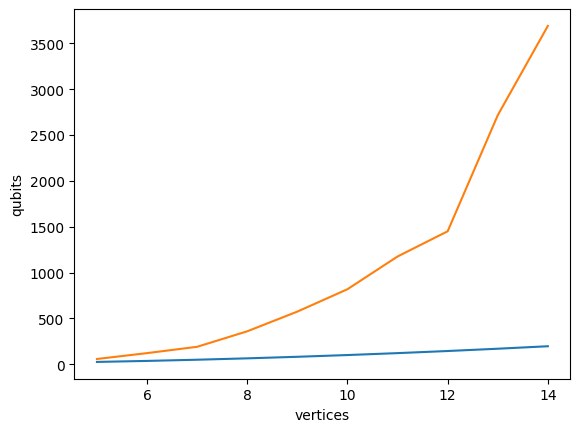

In [64]:
sv = 5   # starting vertex count
v = 10  # how many vertices
g = 1    # number of graph samples

machine = DWaveSampler(solver={'chip_id': 'Advantage_system4.1'})
print('Chip:', machine.properties['chip_id'])
print('Qubits:', machine.properties['num_qubits'])
topology = machine.to_networkx_graph()

l_couplers = np.zeros(v)
p_couplers = np.zeros(v)
l_qubits = np.zeros(v)
p_qubits = np.zeros(v)
x = np.arange(v)+5

for vertices in range(v):
    for seed in range(g):
        G1 = nx.gnp_random_graph(vertices+5, 0.30, seed, directed=False)
        E1 = []
        for e in G1.edges(data=True):
            E1.append((e[0],e[1]))
        p = len(E1)

        mapping = dict(zip(G1.nodes(), sorted(G1.nodes(), key=lambda k: random.random())))
        G2 = nx.relabel_nodes(G1, mapping)
        E2 = []
        for e in G2.edges(data=True):
            E2.append((e[0],e[1]))

        Q = create_qubo_gi(E1,E2,vertices+5,p)
        bqm = BinaryQuadraticModel(Q, 'BINARY')
        l_qubits[vertices] += Q.shape[0]
        l_couplers[vertices] += len(bqm.quadratic)
        embedding = find_embedding(bqm.quadratic, topology)  
        p_qubits[vertices] += sum(len(chain) for chain in embedding.values())
        p_couplers[vertices] += l_couplers[vertices] + sum(len(chain)-1 for chain in embedding.values())
    l_couplers[vertices] /= g
    p_couplers[vertices] /= g
    l_qubits[vertices] /= g
    p_qubits[vertices] /= g

#plt.plot(x, l_couplers)
#plt.plot(x, p_couplers)
plt.plot(x, l_qubits)
plt.plot(x, p_qubits)
plt.ylabel("qubits")
plt.xlabel("vertices")
plt.xlabel("vertices")
plt.show() 
gl_qubits = l_qubits
gp_qubits = p_qubits
gx = x

In [66]:
print(gl_qubits)
print(gp_qubits)

[ 25.  36.  49.  64.  81. 100. 121. 144. 169. 196.]
[  57.  121.  190.  359.  574.  818. 1175. 1450. 2716. 3690.]


## Community detection

Chip: Advantage_system4.1
Qubits: 5760
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54


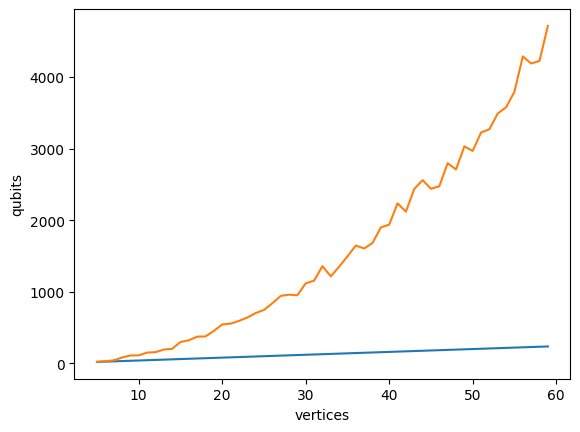

In [67]:
sv = 5   # starting vertex count
v = 55  # how many vertices
g = 1    # number of graph samples
create_qubo = create_qubo_gi

machine = DWaveSampler(solver={'chip_id': 'Advantage_system4.1'})
print('Chip:', machine.properties['chip_id'])
print('Qubits:', machine.properties['num_qubits'])
topology = machine.to_networkx_graph()

l_couplers = np.zeros(v)
p_couplers = np.zeros(v)
l_qubits = np.zeros(v)
p_qubits = np.zeros(v)
x = np.arange(v)+5

for vertices in range(v):
    print(vertices)
    for seed in range(g):
        G = nx.gnp_random_graph(vertices+sv, 0.30, seed, directed=False)
        nx.set_edge_attributes(G, {e: {'weight': random.randint(1, 10)} for e in G.edges})
        p = 0
        for e in G.edges:
            p += G[e[0]][e[1]]['weight']
    
        Q = create_qubo_cd(G,4,p)
        bqm = BinaryQuadraticModel(Q, 'BINARY')
        l_qubits[vertices] += Q.shape[0]
        l_couplers[vertices] += len(bqm.quadratic)
        embedding = find_embedding(bqm.quadratic, topology)  
        p_qubits[vertices] += sum(len(chain) for chain in embedding.values())
        p_couplers[vertices] += l_couplers[vertices] + sum(len(chain)-1 for chain in embedding.values())
    l_couplers[vertices] /= g
    p_couplers[vertices] /= g
    l_qubits[vertices] /= g
    p_qubits[vertices] /= g

#plt.plot(x, l_couplers)
#plt.plot(x, p_couplers)
plt.plot(x, l_qubits)
plt.plot(x, p_qubits)
plt.ylabel("qubits")
plt.xlabel("vertices")
plt.show() 

In [76]:
cl_qubits = l_qubits
cp_qubits = p_qubits
cx = x

print(cl_qubits)
print(cp_qubits)
print(cx)

[ 20.  24.  28.  32.  36.  40.  44.  48.  52.  56.  60.  64.  68.  72.
  76.  80.  84.  88.  92.  96. 100. 104. 108. 112. 116. 120. 124. 128.
 132. 136. 140. 144. 148. 152. 156. 160. 164. 168. 172. 176. 180. 184.
 188. 192. 196. 200. 204. 208. 212. 216. 220. 224. 228. 232. 236.]
[  22.   30.   42.   81.  110.  112.  150.  156.  193.  203.  298.  322.
  373.  376.  453.  544.  555.  593.  640.  703.  746.  839.  942.  960.
  951. 1118. 1155. 1358. 1216. 1350. 1495. 1646. 1605. 1682. 1900. 1938.
 2236. 2120. 2438. 2560. 2439. 2474. 2797. 2709. 3032. 2968. 3226. 3271.
 3492. 3578. 3796. 4289. 4190. 4226. 4715.]
[ 5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28
 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52
 53 54 55 56 57 58 59]


Text(0.5, 1.0, 'Community detection')

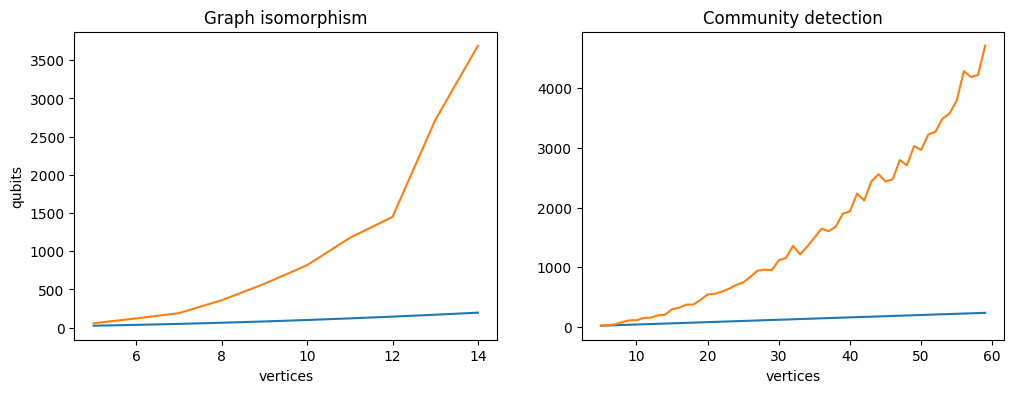

In [95]:
figure, axis = plt.subplots(1, 2) 
figure.set_figheight(4)
figure.set_figwidth(12)
axis[0].plot(gx, gl_qubits, label='logical')
axis[0].plot(gx, gp_qubits, label='physical')
axis[0].set_ylabel("qubits")
axis[0].set_xlabel("vertices")
axis[0].set_title("Graph isomorphism") 
  
# For Cosine Function 
axis[1].plot(cx, cl_qubits, label='logical')
axis[1].plot(cx, cp_qubits, label='physical')
axis[1].set_xlabel('vertices')
axis[1].set_title("Community detection") 